In [1]:
import os
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from scipy import signal, stats
from glob import glob
import copy

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie

In [4]:
from sensory_stim_lag import visual_stim_lag as vislag
from sensory_stim_lag import auditory_stim_lag as audlag

In [5]:
%matplotlib notebook

### Load data

In [6]:
dfolder = r'C:\Users\lesliec\data\eeg_pilot\mouse496220\audio_vis1_2020-06-10_14-54-43\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder, preprocess=False)

sslog_file not found.


In [7]:
sync_data = exp._load_sync_dataset()

In [8]:
eeg_data, eeg_ts = exp.load_eegdata()

#### Load stimulus log and get correct onset times

In [9]:
# stimulus table
stim_file = glob(exp.data_folder + '/*_table.csv', recursive=True)[0]
stim_table = pd.read_csv(stim_file)

# log file
log_file = glob(exp.data_folder + '/*_stimulus_log.csv', recursive=True)[0]
stim_log = pd.read_csv(log_file)

In [10]:
# get sweep and vsync rising and falling times
srising = sync_data.get_edges(keys=('behavior_sweep',), kind='rising', units='seconds')
sfalling = sync_data.get_edges(keys=('behavior_sweep',), kind='falling', units='seconds')

vrising = sync_data.get_edges(keys=('behavior_vsync',), kind='rising', units='seconds')
vfalling = sync_data.get_edges(keys=('behavior_vsync',), kind='falling', units='seconds')

In [11]:
sync_log = stim_log.drop(labels='time', axis='columns')
sync_log['rising_edge'] = vrising
sync_log['falling_edge'] = vfalling

In [12]:
sync_log.head()

,frame,display_stim,stim_type,stim_parameter,rising_edge,falling_edge
0,0,False,gray_screen,none,351.67956,351.76969
1,1,False,gray_screen,none,351.77010,351.77705
2,2,False,gray_screen,none,351.77747,351.79347
3,3,False,gray_screen,none,351.79382,351.81033
4,4,False,gray_screen,none,351.81069,351.82709


In [13]:
stim_table[10:14]

,type,parameter,on_time,duration
10,fullscreen,white,51,0.25
11,fullscreen,black,56,0.25
12,auditory,whitenoise,61,0.25
13,auditory,10000,66,0.25


In [14]:
awake_sweep = stim_table.copy()
awake_sweep['onset_masterclock'] = awake_sweep['on_time'] + srising[0]
awake_sweep.head()

,type,parameter,on_time,duration,onset_masterclock
0,fullscreen,black,1,0.25,352.67778
1,auditory,whitenoise,6,0.25,357.67778
2,auditory,whitenoise,11,0.25,362.67778
3,fullscreen,white,16,0.25,367.67778
4,auditory,whitenoise,21,0.25,372.67778


In [15]:
anest_sweep = stim_table.copy()
anest_sweep['onset_masterclock'] = anest_sweep['on_time'] + srising[1]
anest_sweep.head()

,type,parameter,on_time,duration,onset_masterclock
0,fullscreen,black,1,0.25,1962.06246
1,auditory,whitenoise,6,0.25,1967.06246
2,auditory,whitenoise,11,0.25,1972.06246
3,fullscreen,white,16,0.25,1977.06246
4,auditory,whitenoise,21,0.25,1982.06246


#### Load movies

In [16]:
bodymovie = Movie(filepath=exp.bodymovie_file,
                 sync_filepath=exp.sync_file,
                 sync_channel='behavior_camera'
                 )
eyemovie = Movie(filepath=exp.pupilmovie_file,
                 sync_filepath=exp.sync_file,
                 sync_channel='eye_camera'
                 )
facemovie = Movie(filepath=exp.facemovie_file,
                 sync_filepath=exp.sync_file,
                 sync_channel='face_camera'
                 )

### Choose stim presentation to look at movie

In [32]:
stim_choice = 1 # index of stim to plot

# electrodes to plot
ch_ant = eeg_data[:, 13]
ch_vis = eeg_data[:, 4]

In [33]:
stim_onset = anest_sweep['onset_masterclock'].iloc[stim_choice]
beg_movie = stim_onset - 0.5 # sec, master clock
end_movie = stim_onset + 1.5
moviets = bodymovie.sync_timestamps[np.argwhere((bodymovie.sync_timestamps >= beg_movie) & (bodymovie.sync_timestamps <= end_movie)).flatten()]

In [34]:
eeginds = np.argwhere((eeg_ts >= beg_movie) & (eeg_ts <= end_movie)).flatten()

In [35]:
def update(frame):
    current_time = moviets[frame]
    
    # body cam movie
    bax.set_data(bodymovie.get_frame(time=current_time))
    
    # eeg plot
    visline.set_data([current_time, current_time], [0,1])
    antline.set_data([current_time, current_time], [0,1])
    
    return fig

C:\Users\lesliec\data\eeg_pilot\mouse496220\audio_vis1_2020-06-10_14-54-43\recording1\whitenoise_eeg_anest.mp4


<IPython.core.display.Javascript object>


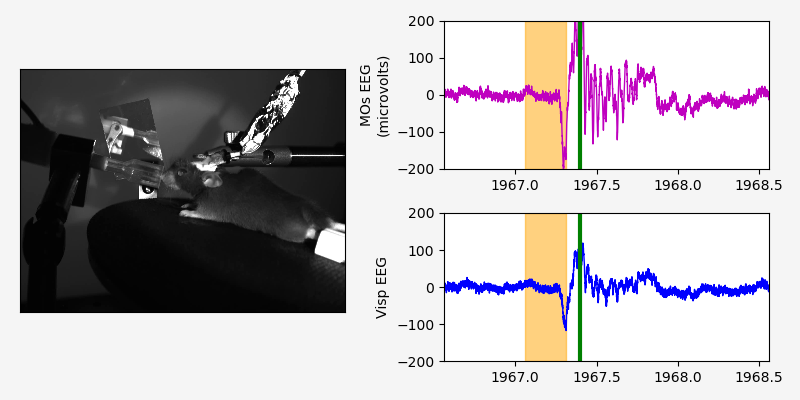

In [36]:
movie_name = os.path.join(exp.data_folder, 'whitenoise_eeg_anest.mp4')
print(movie_name)

fig = plt.figure(figsize=(8, 4))
fig.patch.set_facecolor('whitesmoke')

timezero = moviets[0]

# make grid for subplots
gs = GridSpec(2, 2, figure=fig)
ax_body = fig.add_subplot(gs[:, 0])
ax_ant = fig.add_subplot(gs[0, 1])
ax_vis = fig.add_subplot(gs[1, 1])

# body cam movie
bax = ax_body.imshow(bodymovie.get_frame(time=timezero))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)

# EEG plot (vis)
ax_vis.plot(eeg_ts[eeginds], ch_vis[eeginds], 'b', linewidth=1)
ax_vis.set_xlim((eeg_ts[eeginds[0]], eeg_ts[eeginds[-1]]))
ax_vis.set_ylim((-200, 200))
ax_vis.set_ylabel('Visp EEG')
ax_vis.axvspan(stim_onset, stim_onset+0.25, color='orange', alpha=0.5)
visline = ax_vis.axvline(x=timezero, color='green', linewidth=3)

# EEG plot (ant)
ax_ant.plot(eeg_ts[eeginds], ch_ant[eeginds], 'm', linewidth=1)
ax_ant.set_xlim((eeg_ts[eeginds[0]], eeg_ts[eeginds[-1]]))
ax_ant.set_ylim((-200, 200))
ax_ant.set_ylabel('MOs EEG\n(microvolts)')
ax_ant.axvspan(stim_onset, stim_onset+0.25, color='orange', alpha=0.5)
antline = ax_ant.axvline(x=timezero, color='green', linewidth=3)

gs.tight_layout(fig)

anim = animation.FuncAnimation(fig, update, init_func=None, frames=len(moviets), interval=200, blit=False)
# anim.save(movie_name, writer='ffmpeg', fps=5, extra_args=['-vcodec', 'libx264'], dpi=300)

In [20]:
# time to investigate
inv_time = awake_sweep['onset_masterclock'].iloc[10] - 3 # sec, master clock
end_time = awake_sweep['onset_masterclock'].iloc[13] + 2 # sec
inv_movietimes = bodymovie.sync_timestamps[np.argwhere((bodymovie.sync_timestamps >= inv_time) & (bodymovie.sync_timestamps <= end_time)).flatten()]
print(len(inv_movietimes))
print(inv_time)
print(end_time)

563
399.67778
419.67778


In [57]:
stim_list = []
for ttime in inv_movietimes:
    if (ttime > awake_sweep['onset_masterclock'].iloc[10]) & (ttime < awake_sweep['onset_masterclock'].iloc[10]+0.25):
        stim_list.append('white screen')
    elif (ttime > awake_sweep['onset_masterclock'].iloc[11]) & (ttime < awake_sweep['onset_masterclock'].iloc[11]+0.25):
        stim_list.append('black screen')
    elif (ttime > awake_sweep['onset_masterclock'].iloc[12]) & (ttime < awake_sweep['onset_masterclock'].iloc[12]+0.25):
        stim_list.append('whitenoise')
    elif (ttime > awake_sweep['onset_masterclock'].iloc[13]) & (ttime < awake_sweep['onset_masterclock'].iloc[13]+0.25):
        stim_list.append('10 kHz tone')
    else:
        stim_list.append('')
print(len(stim_list))

563


In [62]:
def update(frame):
    current_time = inv_movietimes[frame]
    
    # body cam movie
    bax.set_data(bodymovie.get_frame(time=current_time))
    
    # update text
    time_text.set_text(stim_list[frame])
    
    return fig

In [67]:
movie_name = os.path.join(exp.data_folder, 'stim_sample_awake.mp4')
print(movie_name)

C:\Users\lesliec\data\eeg_pilot\mouse496220\audio_vis1_2020-06-10_14-54-43\recording1\stim_sample_awake.mp4


<IPython.core.display.Javascript object>


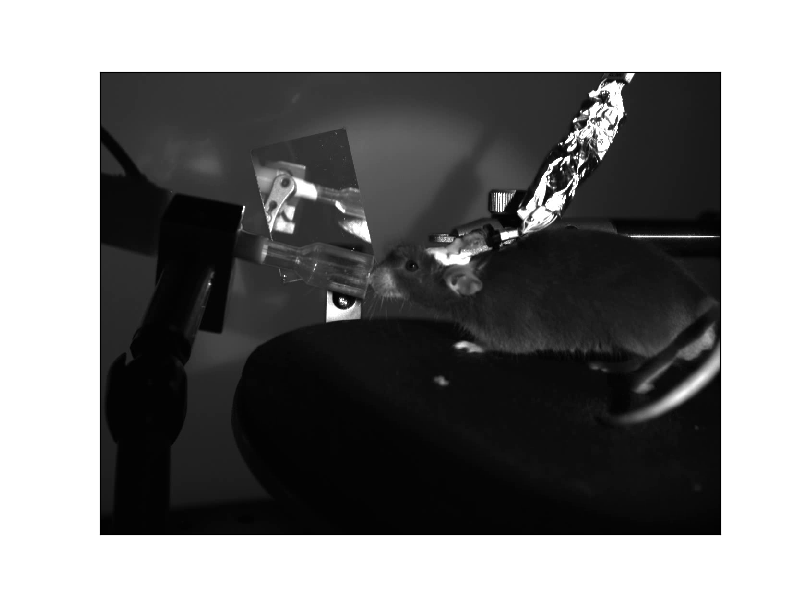

In [74]:
fig = plt.figure(figsize=(8, 6))
# fig.patch.set_facecolor('whitesmoke')

timezero = inv_movietimes[0]

ax_body = fig.add_subplot()

# body cam movie
bax = ax_body.imshow(bodymovie.get_frame(time=timezero))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)

# add text
time_text = ax_body.text(0.02, 0.05, 'STIMULUS', color='white', fontsize=14, transform=ax_body.transAxes)

anim = animation.FuncAnimation(fig, update, init_func=None, frames=len(inv_movietimes), interval=35, blit=False)
# anim.save(movie_name, writer='ffmpeg', fps=28, extra_args=['-vcodec', 'libx264'], dpi=300) # fps=30